# Single-Object Detection

Object detection is the process of finding locations of specific objects in images. Depending on the number of objects in images, we may deal with single-object or multi-object detection problems. In single-object detection, we are attempting to locate only one object in a given image. The location of the object can be defined by a bounding box.

As an example, the following screenshot depicts the location of the fovea (a small pit) in an eye image using a green bounding box:

![](fovea.png)

We can represent a bounding box with four numbers in one of the following formats:

* $[x_0, y_0, w, h]$
* $[x_0, y_0, x_1, y_1]$
* $[x_c, y_c, w, h]$

Here, the preceding elements represent the following:

* $x_0, y_0$: The coordinates of the top left of the bounding box
* $x_1, y_1$: The coordinates of the bottom right of the bounding box
* $w, h$: The width and height of the bounding box
* $xc, yc$: The coordinates of the centroid of the bounding box

As an example, let's look at the following screenshot in which $x_c, y_c = 1099, 1035; w, h = 500, 500; x_0, y_0 = 849, 785$; and $x_1, y_1 = 1349, 1285$:

![](boxed_fovea.png)

Therefore, the goal of single-object detection will be to predict a bounding box using four numbers. In the case of square objects, we can fix the width and height and simplify the problem to predict just two numbers.

## **Exploratory data analysis**

EDA is usually performed to understand the characteristics of data. In EDA, we will inspect our dataset and visualize samples or statistical features of our data using boxplots, histograms and other visualization tools. For instance, for tabular data, we would like to see the columns, a few rows a number of records, and statistical metrics, such as the mean and standard deviation of our data. For imaging data, we would display sample images, labels, or bounding boxes of the objects in the images.

We will use the data from thee **iChallenge-AMD** competition on the Grand Challenge website. This competition has multiple tasks, including classification, localization, and segmentation. We are only interested in the localization task. In this recipe, we will explore the iChallenge-AMD dataset.

### **Getting ready**

1. To find the dataset, visit https://amd.grand-challenge.org/.

### **How to do it**

To explore the dataset, we begin by loading the labels and displaying sample images

In [209]:
# 1 Let's begin by loading Fovea_location.xlxs and printing out its head
import os
import pandas as pd

path2data = "../data/iChallenge-AMD/"

path2labels = os.path.join(path2data, "Training400", "Fovea_location.xlsx")

# make sure to install xlrd
labels_df = pd.read_excel(path2labels, index_col="ID")
labels_df.head()

imgName      Fovea_X      Fovea_Y
ID                                     
1   A0001.jpg  1182.264278  1022.018842
2   A0002.jpg   967.754046  1016.946655
3   A0003.jpg  1220.206714   989.944033
4   A0004.jpg  1141.140888  1000.594955
5   A0005.jpg  1127.371832  1071.109440

In [210]:
# 2 Next, we print the tail of the excel file
labels_df.tail()

imgName     Fovea_X     Fovea_Y
ID                                    
396  N0307.jpg  823.024991  690.210211
397  N0308.jpg  647.598978  795.653188
398  N0309.jpg  624.571803  755.694880
399  N0310.jpg  687.523044  830.449187
400  N0311.jpg  746.107631  759.623062

<AxesSubplot:xlabel='Fovea_X', ylabel='Fovea_Y'>

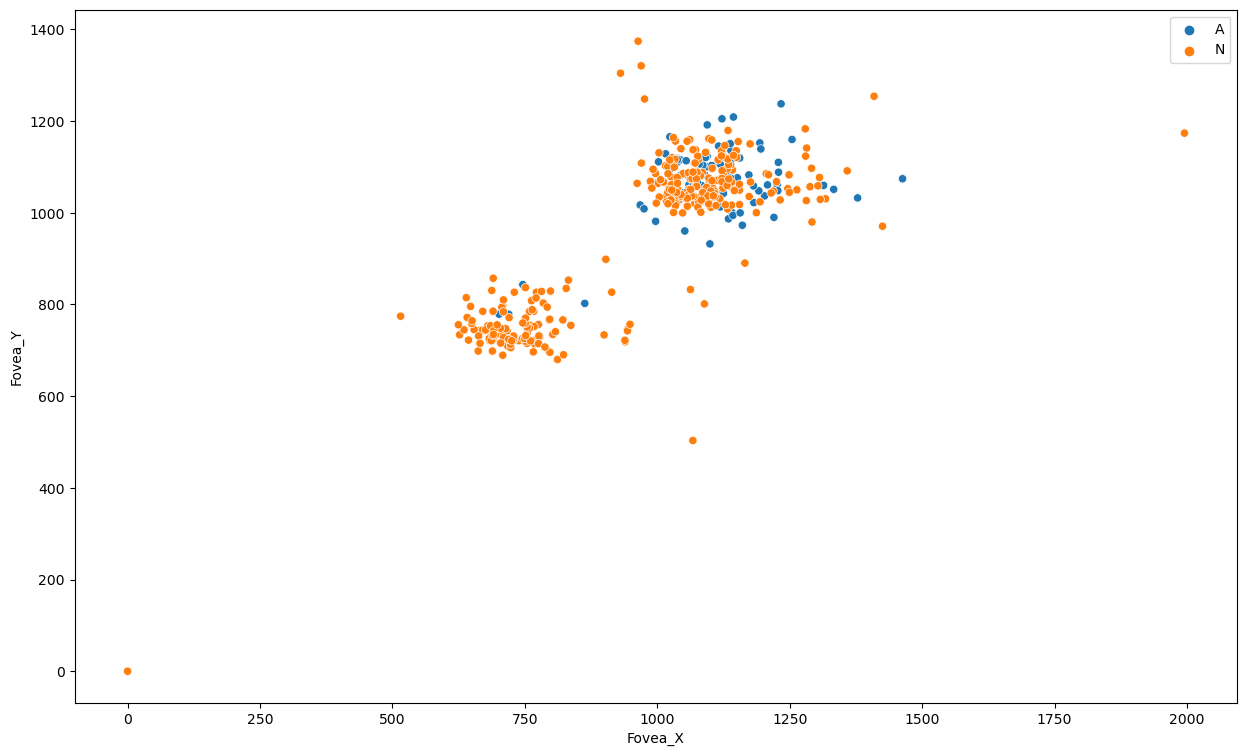

In [211]:
# 3 The we will show the scatter plot of the Fovea_X and Fovea_Y coordinates
import seaborn as sns
%matplotlib inline

AorN = [imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'], hue=AorN)

In [212]:
# 4 Next, we will show a few samples images
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)
# Then, we will set the plot parameters:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows, ncols = 2, 3
# Then, we will select a random set of image ids:
imgName=labels_df["imgName"]
ids=labels_df.index
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 73 371 160 294 217 191]


<Figure size 1500x900 with 0 Axes>

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


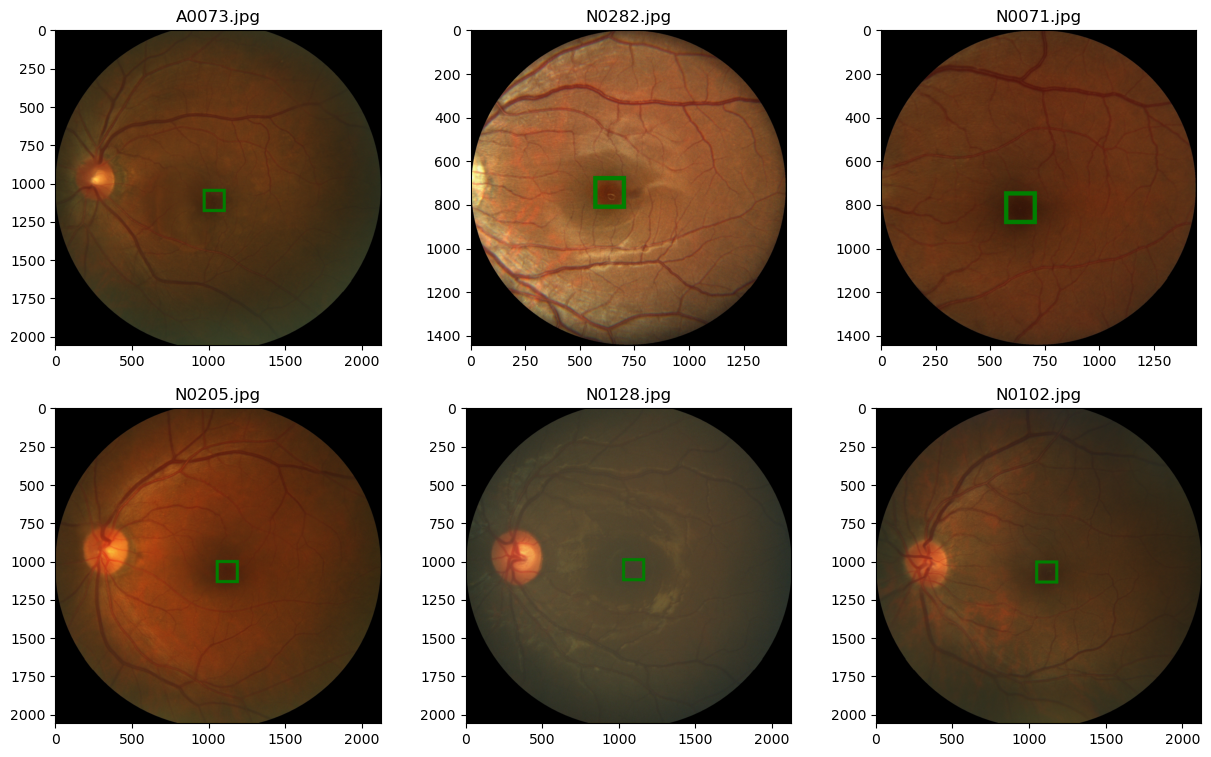

In [213]:
# Next, we will define a helper function to load an image and its label from the local files:
def load_img_label(labels_df, id_): 
    imgName = labels_df["imgName"] 
    if imgName[id_][0] == "A":
        prefix="AMD"
    else:
        prefix = "Non-AMD"
    fullPath2img = os.path.join(path2data, "Training400", prefix, imgName[id_])
    img = Image.open(fullPath2img)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x, y)
    return img,label

# Next, we will define a helper function to show the image and label as a bounding box:
def show_img_label(img,label,w_h=(50, 50),thickness=2):   
    w, h = w_h                   
    cx, cy = label   
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline="green", width=thickness)
    plt.imshow(np.asarray(img))


# Then, we will show the selected images together with the fovea bounding boxes:
for i,id_ in enumerate(rndIds):
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

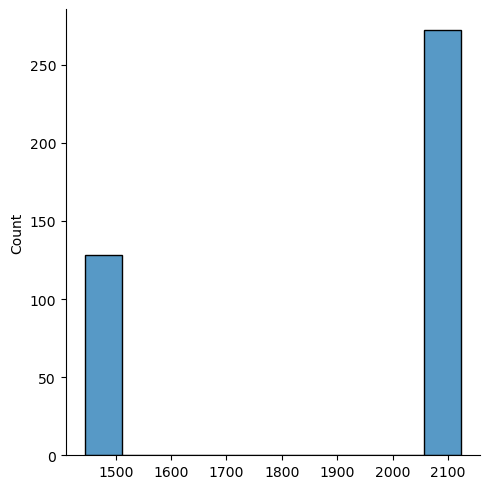

In [214]:
# 5 Next, we will collect the image widths and heights in 2 lists
h_list, w_list = [], []
for id_ in ids:
    if imgName[id_][0] == "A":
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
    fullPath2img = os.path.join(path2data, "Training400", prefix, imgName[id_])
    img = Image.open(fullPath2img)
    h, w = img.size
    h_list.append(h)
    w_list.append(w)

# 6 Then we will plot the distributions of heights and widths
# plot the distribution of the image heights as follows
sns.displot(data=h_list, kde=False)

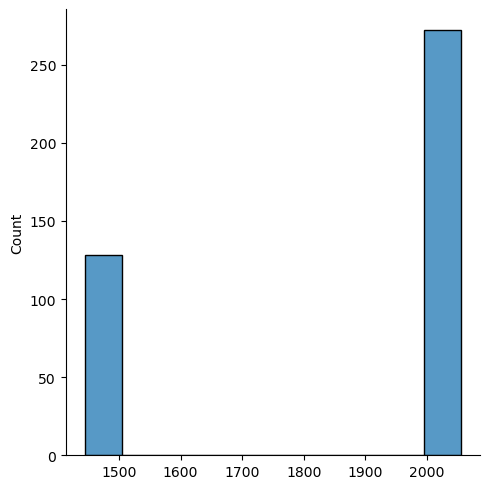

In [215]:
# Next, we will plot the distribution of the image widths:
sns.displot(data=w_list, kde=False)

### **How it works**

In step 1, we loaded the labels from the Excel file. We used the pandas library and assumed that Fovea_location.xlsx is located in the `./data/Training400` folder. On Windows machines, you might not need to install anything. For Linux machines, to load Excel files using `pandas`, install the `openpyxl` package in your conda environment using the following command:
```bash
$ conda install -c anaconda openpyxl
```
Then, we loaded the file into a pandas DataFrame and printed out its head. The DataFrame has three columns: imgName, `Fovea_X`, and `Fovea_Y`. The `imgName` column refers to the image filename, while `Fovea_X` and `Fovea_Y` represent the `X` and `Y` coordinates of the fovea center. Note that the first 89 rows correspond to the `AMD` images and start with the letter `A`.

In step 2, we printed out the tail of the DataFrame. You can see that `ID` reaches `400`, the same as the number of images. Also, note that the last 311 rows correspond to the Non-AMD images and start with the letter `N`.

In step 3, we showed the scatterplot of `Fovea_X` and `Fovea_Y`. We used the `seaborn` library to show the scatterplot. Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

As has been observed, the centers are clustered into two groups. Also, there is no correlation between the image class (AMD versus Non-AMD) and the fovea location. It is also interesting to see that there are a few images with the fovea at the `(0,0)` coordinates. We can drop zero values from the DataFrame, as shown in the following code block:

```python
labels_df = labels_df.replace(0, None)
labels_df.dropna
```

However, since there are only a few images like this, we opted to keep them.

In step 4, we displayed a few random images with the fovea bounding boxes. The fovea location is given as a center point. Therefore, to show a bounding box, we create a rectangle using `rectangle` from the `PIL.imageDraw` package at the center of the fovea. We also printed the image sizes. As we saw, images have different sizes.

In step 5, we get lists of image heights and widths. This will be used to plot the distributions of heights and widths in step 6. The plots of distributions reveal that the majority of heights and width are in the range of 1900 to 2100. 

## **Data transformation for object detection**

**Data augmentation and transformation is a critical step in training deep learning algorithms, especially for small datasets**. The iChallenge-AMD dataset in this chapter **has only $400$ images, which is considered a small dataset**. As a reminder, we will later split $20\%$ of this dataset for evaluation purposes. **Since the images have different sizes, we need to resize all images to a pre-determined size**. Then, we can utilize a variety of **augmentation techniques, such as horizontal flipping, vertical flipping, and translation, to expand our dataset during training**. 

In object detection tasks, **when we perform such transformations on images, we also need to update the labels**. For instance, **when we flip an image horizontally, the location of objects in the image will change**. While `torchvision.transforms` provides utility functions for image transformations, **we need to build our own functions for updating the labels**. In this recipe, we will develop **a pipeline for transforming images and labels in single-object detection. We will develop horizontal flipping, vertical flipping, translation, and resizing. You can then add more transformations to the pipeline as you need**. 

### **How to do it**

We will create a data transformation pipeline for single-object detection:

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


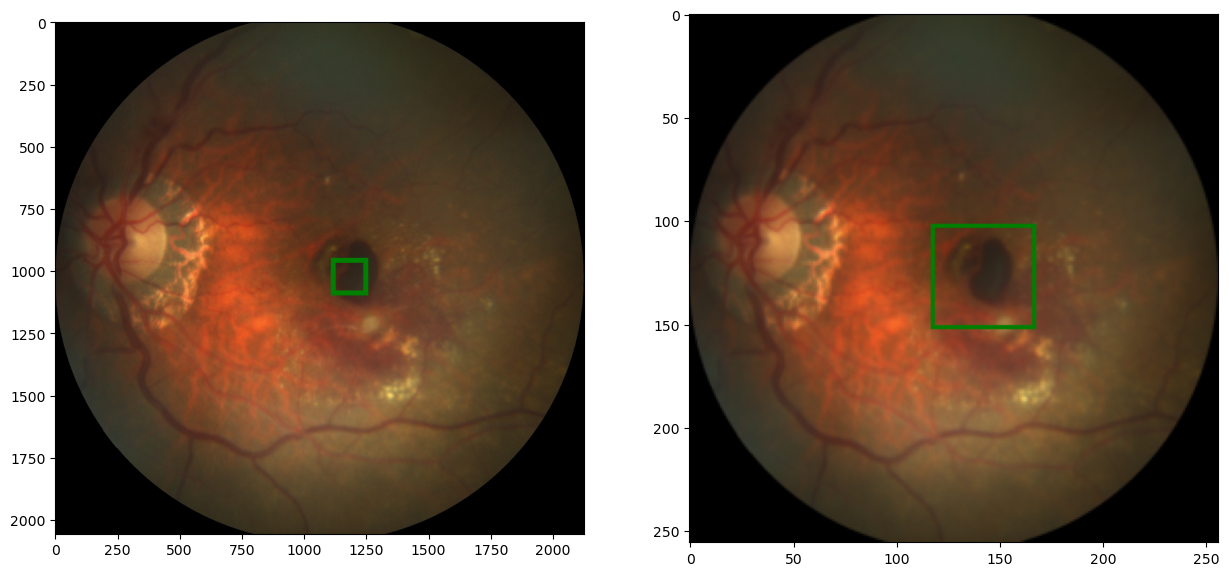

In [216]:
# 1 First, we will define a helper function to resize images:
import torchvision.transforms.functional as TF

def resize_img_label(image, label=(0., 0.), target_size=(256, 256)):
    w_orig, h_orig = image.size   
    w_target, h_target = target_size
    cx, cy = label

    image_new = TF.resize(image, target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new, label_new

# Let's try resizing an image using the preceding function:
img, label = load_img_label(labels_df, 1)   
print(img.size, label)

img_r, label_r = resize_img_label(img,label)
print(img_r.size, label_r)

plt.subplot(1, 2, 1)
show_img_label(img, label, w_h = (150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(img_r, label_r)

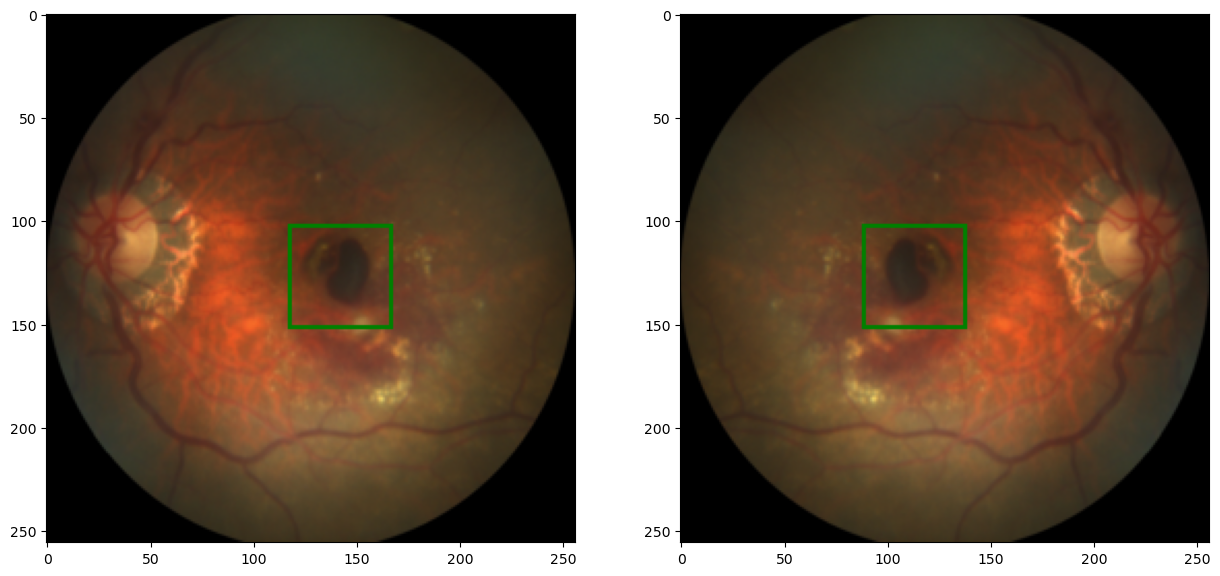

In [217]:
# 2 Next, we will define a helper function to randomly flip images
# horizontally
def random_hflip(image, label):
    w, h = image.size
    x, y = label

    image = TF.hflip(image)
    label = w-x, y
    return image, label

# Let's try flipping an image using the preceding function:
img, label = load_img_label(labels_df,1)   
img_r, label_r = resize_img_label(img,label)
img_fh, label_fh = random_hflip(img_r,label_r)
plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1,2,2)
show_img_label(img_fh, label_fh)

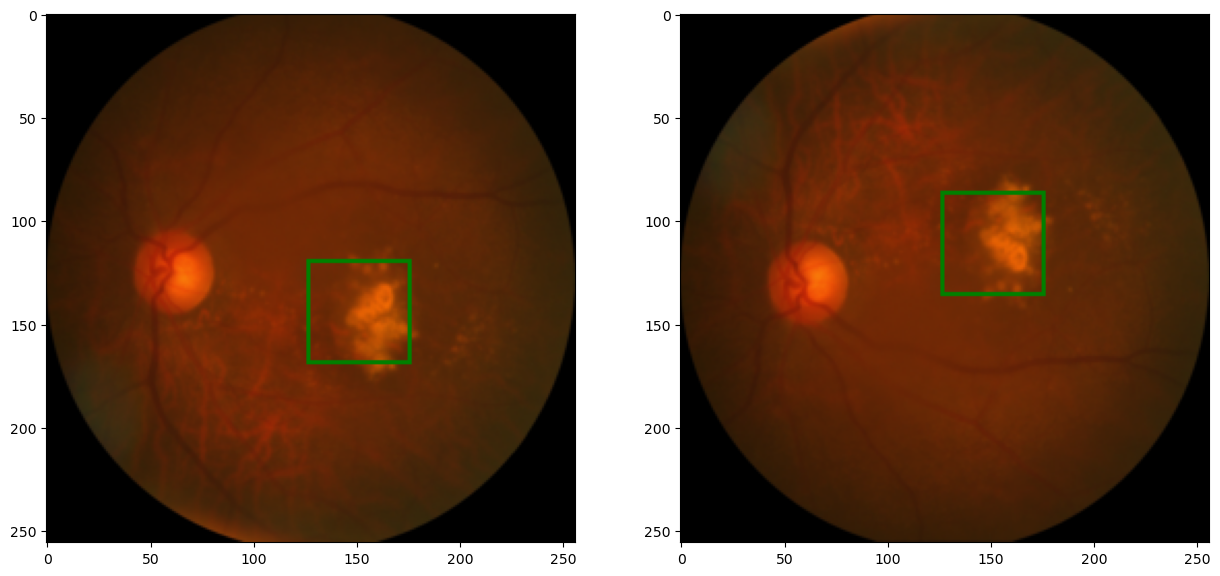

In [218]:
# 3 Next, we will define a function to randomly flip images vertically:
def random_vflip(image,label):
    w,h = image.size
    x,y = label

    image = TF.vflip(image)
    label = x, w-y
    return image, label

# Let's try flipping an image using the preceding function
img, label = load_img_label(labels_df,7)   
img_r, label_r = resize_img_label(img, label)
img_fv, label_fv = random_vflip(img_r, label_r)

plt.subplot(1,2,1)
show_img_label(img_r, label_r)
plt.subplot(1,2,2)
show_img_label(img_fv, label_fv)

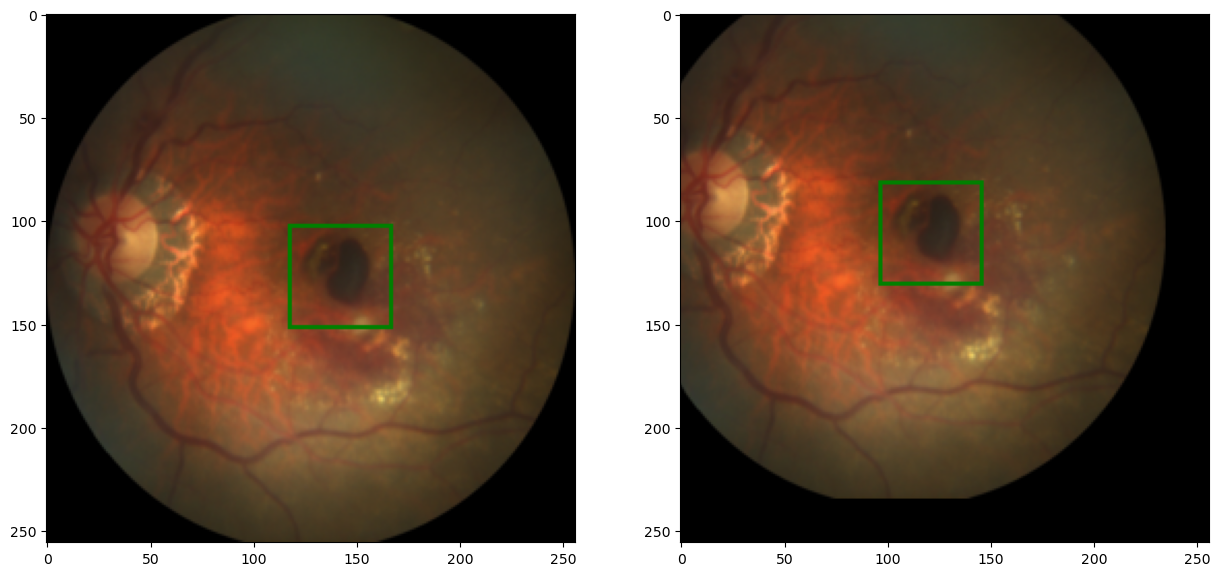

In [219]:
# 4 Next, we will define a helper function to randomly shift or translate images
# in either direction:
import numpy as np
np.random.seed(1)

def random_shift(image,label,max_translate=(0.2,0.2)):
    w, h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label

# Let's try translating an image using the random_shift function:
img, label = load_img_label(labels_df, 1)   
img_r, label_r = resize_img_label(img, label)
img_t, label_t = random_shift(img_r,label_r, max_translate=(.5, .5))

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)

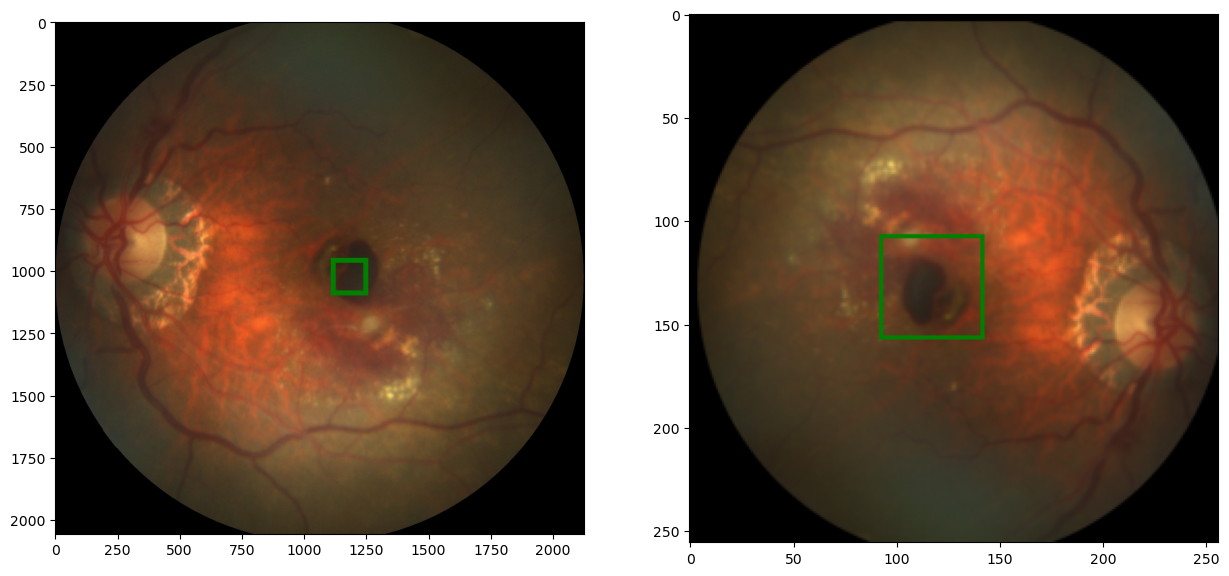

In [220]:
# 5 Next, we will compose multiple transformations into
# one function to define transformer:
import random
np.random.seed(0)
random.seed(0)

def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
    if random.random() < params["p_vflip"]:            
        image, label = random_vflip(image, label)
    if random.random() < params["p_shift"]:                            
        image, label = random_shift(image, label, params["max_translate"])
    image = TF.to_tensor(image)
    return image, label

# Let's try to transform an image using transformer:
img, label = load_img_label(labels_df, 1) 

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.2, 0.2),
}
img_t, label_t = transformer(img,label,params)

# Then, we will show the original and transformed images:
plt.subplot(1, 2, 1)
show_img_label(img,label, w_h = (150, 150), thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t), label_t)

### **How it works**

How it works...
In step 1, we defined a helper function to resize `PIL` images and update the labels to a target size. For resizing PIL images, we can use the `resize` function from `torchvision.transforms.functional`. As a reminder, PIL returns the image size in this format: `width, height= image.size`. This could be confusing and is sometimes a source of bugs if you worked with the `OpenCV` package.

> `PIL` returns the image size in the format of `width, height= image.size`.

To update the label, the fovea coordinates, we need to scale the coordinate by the factor of resizing in each dimension. This factor will be `w_target/w_orig` and `h_target/h_orig` for the `x` and `y` coordinates, respectively. To load and show the sample image and label, we use the helper functions developed in the Exploratory data analysis recipe.

In step 2, we built a helper function to horizontally flip images and labels. We used the hflip function from `torchvision` to horizontally flip images. In the case of a horizontal flip, the y coordinate remains the same and only the x coordinate of the fovea location will change to width - x. Check out the image before and after flipping and notice how the eye disk is moved from the left side to the right side of the image.

In step 3, we built a helper function to vertically flip images and labels. We used the `vflip` function from `torchvision` to vertically flip images. In the case of vertical flipping, the x coordinate remains the same and only the y coordinate of the fovea location will change to `height - y`. Check out the image before and after flipping and notice how the location of the fovea and eye disk are changed.

In step 4, we defined a function to shift or translate images to the left, right, up, or down. The amount of translation is chosen randomly; however, it is bounded by the `max_translate = (0.2, 0.2)` parameter. This means that the maximum translation in x and y dimensions will be `0.2*width` and `0.2*height`. For example, for an image size of $256 \times 256$, the maximum translation will be $51$ pixels in each direction. To set the maximum image translation during data augmentation, consider the location of the object of interest. You do not want the object to fall outside the image after translation. For most problems, a value in the range of $[0.1, 0.2]$ is safe. However, make sure to adjust this value according to your specific problem. Also, to randomly translate the image in either direction (left, right, up, or down), we generate a random value in the range of [-1, 1] and multiply it by the maximum translation.

To translate images, we use the `affine` function from `torchvision`. This function can perform other types of transformations, such as rotation, shearing, and scaling. Here, we only used the translation feature. Lastly, both x and y coordinates of the fovea center could change by the amount of translation.

In step 5, we stacked multiple transformations into one function. We will later pass the transformation function to the dataset class. As has been observed from the transformed images, five transformations are sequentially applied to the PIL image. You should pay attention to the order of the functions when building custom transformations. For instance, it is better to resize the image first to reduce the computational complexity of other transformations. Moreover, converting to tensors using `TF.to_tensor` goes at the end. This transformation scales `PIL` images to the range of $[0, 1]$ and reshapes images into the `[channel, height, width]` shape. As a result, to display the transformed image, we use `TF.to_pil_image()` to convert it back to a `PIL` image. We also parameterized the augmentation parameters so that you can play with different values. If you want to disable a transformation, you can simply set the probability to zero, as we will do for the validation dataset. A common value for the probability of transformation is $0.5$. Here, to force all transformations, we set the probabilities to `1.0`.

### **There's more**

There are other types of transformations that you can apply to images for data augmentation. Some of them do not require any update to the label.

For example, we can create new images by adjusting the brightness, as shown in the following code block:

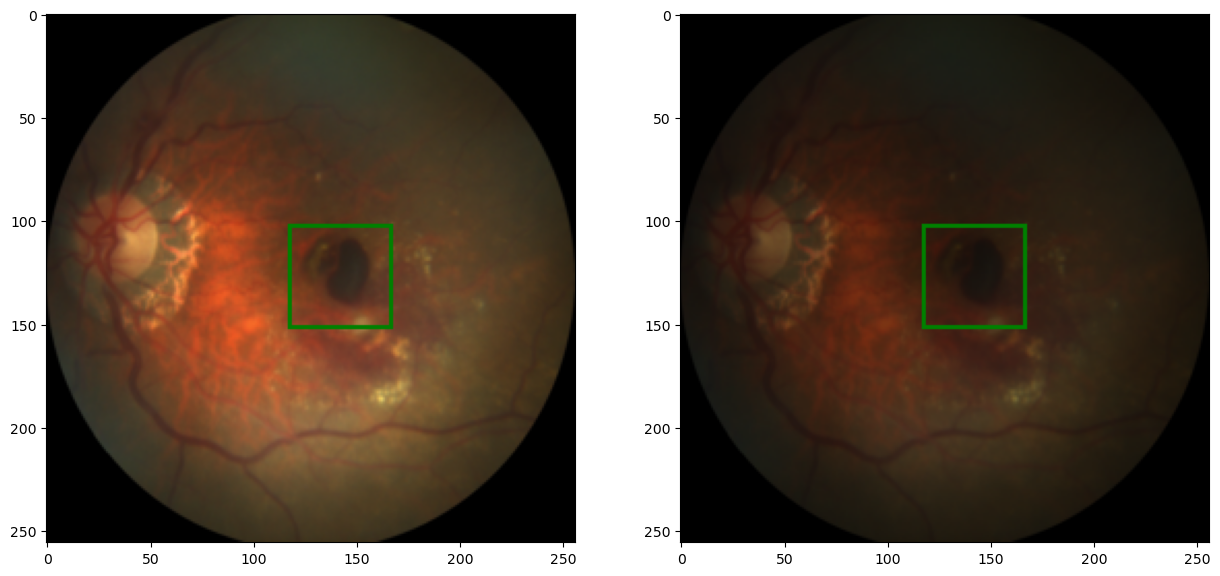

In [221]:
img, label = load_img_label(labels_df, 1)   

# resize image and label
img_r, label_r = resize_img_label(img, label)

# adjust brightness
img_t = TF.adjust_brightness(img_r, brightness_factor=0.5)
label_t = label_r

plt.subplot(1, 2, 1)
show_img_label(img_r, label_r)
plt.subplot(1, 2, 2)
show_img_label(img_t, label_t)

Similarly, we can create new images by adjusting the contrast and gamma correction, as shown in the following code block:

```python
img_t = TF.adjust_contrast(img_r, contrast_factor=0.4) # brightness
img_t = TF.adjust_gamma(img_r, gamma=1.4) # gamma correction
```

There is another transformation that **we usually perform on the labels. In this transformation, we scale the labels to the range of $[0, 1]$** using the following function:

In [222]:
def scale_label(a,b):
    div = [ai/bi for ai, bi in zip(a,b)]
    return div

> For objection detection tasks, it is important to scale the labels to the range of [0, 1] for better model convergence.

We can integrate these transformations into the transformer function, as shown in the following code block:

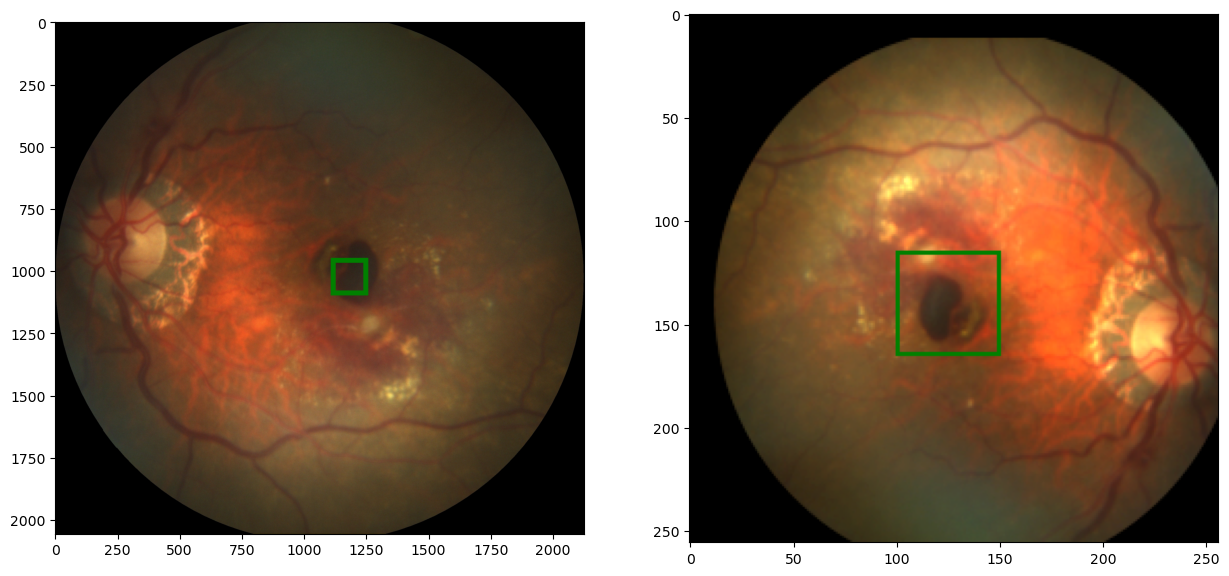

In [223]:
def transformer(image, label, params):
    # previous transformations here 
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image, label)
        
    if random.random() < params["p_vflip"]:            
        image, label = random_vflip(image, label)

    if random.random() < params["p_shift"]:                            
        image, label = random_shift(image, label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor = 1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image, brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image = TF.adjust_contrast(image, contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma = 1+(np.random.rand()*2-1)*params["gamma"]
        image = TF.adjust_gamma(image, gamma)

    if params["scale_label"]:
        label = scale_label(label, params["target_size"])
        
    image = TF.to_tensor(image)
    return image, label

# Let's try to transform an image using the latest transformer function.
np.random.seed(0)
random.seed(0)

# load image and label
img, label = load_img_label(labels_df, 1)

# Set the transformation parameters and then apply the transformations:

params = {
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}
img_t, label_t = transformer(img, label, params)

# Then, show the original and transformed images by executing the following code snippet:
plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(TF.to_pil_image(img_t), label_t)

In [224]:
# Lastly, to rescale the labels back to the image size, use the following helper function:
def rescale_label(a, b):
    div = [ai * bi for ai, bi in zip(a,b)]
    return div

## **Creating custum datasets**

In this recipe, we will use the `Dataset` class from `torch.utils.data` to create custom datasets for loading and processing data. We can do this by sub-classing the `Dataset` class and overriding `__init__` and the `__getitem__` functions. The `__len__` function returns the dataset length and is callable with the Python `len` function. The `__getitem__` function returns an image at the specified index. Then, we will use the `Dataloader` class from `torch.utils.data` to create data loaders. Using data loaders, we can automatically get mini-batches of data for processing.

### **How to do it**

We will create the **trainind** and **validation** datasets and the **data loaders**

In [225]:
# 1 Let's define a custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import os

# Then we will define the bulk of the dataset class
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):
        path2labels = os.path.join(path2data, "Training400", "Fovea_location.xlsx")
        labels_df = pd.read_excel(path2labels, index_col = "ID")
        self.labels = labels_df[["Fovea_X", "Fovea_Y"]].values
        
        self.imgName = labels_df['imgName']
        self.ids = labels_df.index
        
        self.fullPath2img = [0] * len(self.ids)
        for id_ in self.ids:
            if self.imgName[id_][0] == "A":
                prefix = "AMD"
            else:
                prefix = "Non-AMD"
            self.fullPath2img[id_-1]=os.path.join(path2data, "Training400", prefix, self.imgName[id_])
        self.transform = transform
        self.trans_params = trans_params

    def __len__(self):
        # return the size of the dataset
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.fullPath2img[idx])
        label = self.labels[idx]
        image, label = self.transform(image, label, self.trans_params)
        return image, label

In [226]:
# 2 Next, we will create 2 objects of AMD_dataset
# 1st we will define the transformation parameters for the trainind dataset
trans_params_train = {
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,    
}

# Then, we will define the transformation parameters for the validation dataset:
trans_params_val = {
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,    
}

# Then, two objects of the AMD_dataset class will be defined:
amd_ds1 = AMD_dataset(path2data, transformer, trans_params_train)
amd_ds2 = AMD_dataset(path2data, transformer, trans_params_val)

In [227]:
# 3 Next, we will split the dataset into training and validation sets.
# 1st, we will split the image indices into two groups:
from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [228]:
# Then, we will define the training and validation datasets:
from torch.utils.data import Subset

train_ds = Subset(amd_ds1, train_index)
print(len(train_ds))

val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

320
80


torch.Size([3, 256, 256])


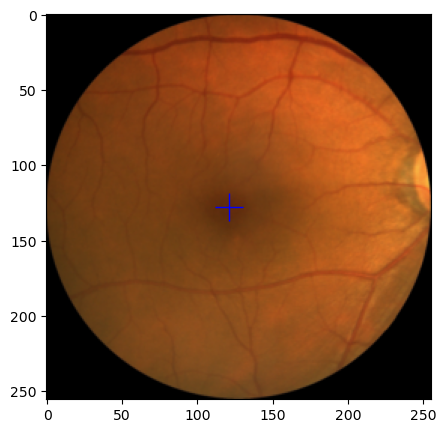

In [230]:
# 4 Let's now show a sample image from train_ds and val_ds.
# First, we will import the required packages:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

# Then, we will define a function to show a tensor image and its label:
def show(img, label=None):
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if label is not None:
        label = rescale_label(label, img.shape[1:])        
        x, y = label
        plt.plot(x, y, 'b+', markersize=20)

# Then, we will show a sample image from train_ds:
plt.figure(figsize=(5, 5))
for img, label in train_ds:
    print(img.shape)
    show(img, label)
    break

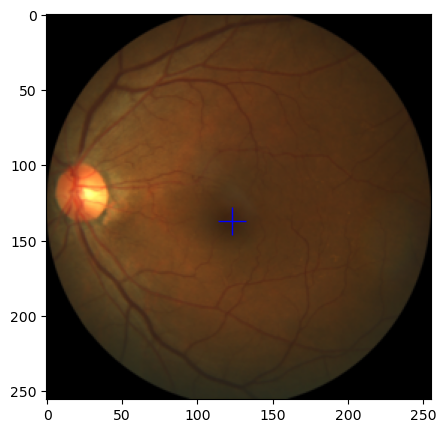

In [231]:
# Similarly, we can show a sample image from val_ds:
plt.figure(figsize=(5, 5))
for img,label in val_ds:
    show(img, label)
    break

In [232]:
# 5 Next, we will define two data loaders for the training and validation datasets:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

# 6 Let's get a batch of data from train_dl:
# To get a batch, we can break the following loop after one iteration:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.4630, 0.5992, 0.4644, 0.5176, 0.4679, 0.5459, 0.5146, 0.4485],
       dtype=torch.float64), tensor([0.5780, 0.5547, 0.4564, 0.4243, 0.4946, 0.4914, 0.5132, 0.4490],
       dtype=torch.float64)]


In [233]:
# Notice that the label batch is returned as a list.
# Thus, we will need to convert the list to a tensor,
# as shown in the following code block:

import torch

# extract a batch from training data
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)

    # convert list to tensor
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


In [234]:
# 7 Similarly, we will get a batch from val_dl:
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)

    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


### **How it works**

In step 1, we defined the custom dataset class. For better code readability, we presented this step in a few snippets. We first defined the bulk of the dataset class. Then, we implemented the `__init__` function. In this function, we loaded the fovea coordinates from `Fovea_location.xlsx` into `self.labels` to be used as labels. To be able to load the images from local files, we also get the full path to images in `self.fullPath2img`. As we found out in the Exploratory data analysis recipe, $89$ images are in the AMD folder and their names start with the letter `A`, and the remainder are in the Non-AMD folder and their names start with the letter `N`. Therefore, we used the first letter to find the image folder and set `prefix` accordingly. Lastly, we set the transformer and transformation parameters. Next, we defined the `__getitem__` function. In this function, we load an image and its label and then transform them using the transformer function. In the end, we overrode the two class functions with `__init__` and `__getitem__`.

In step 2, we created two objects of the `AMD_dataset` class. This is for data-splitting purposes and will be cleared in the next step. We defined two transformation parameters, `trans_params_train` and `trans_params_val`, and passed them to the two instances, respectively. `trans_params_train` defined the transformations that we want to apply to the training dataset. Thus, we enabled all of the data transformation functions implemented in the Data transformation for object detection recipe with the probability of $0.5$. On the other hand, `trans_params_val` defined the transformations that we want to apply to the validation dataset. Thus, we disabled all data augmentation functions by setting their probabilities to $0.0$. Only the resizing of images to 256*256 and the scaling of labels to the range of $[0, 1]$ were enabled for both the training and validation datasets.

In step 3, we created the training and validation datasets by splitting images into two groups. To this end, we first split the image indices using `ShuffleSplit` from `sklearn`. We assigned $20\%$ of the images to the validation dataset. This resulted in $320$ images for training and $80$ for evaluation. Then, we utilized the `Subset` class from torch.utils to subset `train_ds` from the `amd_ds1` dataset at the train_index indices. Similarly, we subset `val_ds` from the `amd_ds2` dataset at the `val_index` indices. Note that train_ds inherits the transformer function of `amd_ds1`, while `val_ds` inherits the transformer function of `amd_ds2`. By now, it should be clear to you why we defined two instances of the `AMD_dataset` class in the first place: to have different transformations for the training and validation datasets. If you only define one object of the dataset class and pass different indices, they will have the same transformation function.

> If you want to split one PyTorch dataset into two training and validation datasets using Subset or random_split from torch.utils.data, define two objects of the dataset class. If you only define one instance of the dataset class and create subset datasets by passing the difference indices, they will get the same transformation function.

In step 4, we depicted a sample image from both `train_ds` and `val_ds`. We defined a helper function to display a tensor image together with its label as a + marker. The tensor was in the `C x H x W`, shape so we reshaped it to `H x W x C`. The label contains the rescaled x and y coordinates. Thus, we rescaled it back to the image size. We first depicted a sample image from `train_ds`. If you rerun this snippet, you should see a different version of the sample image due to random transformations. Next, we showed a sample image from `val_ds`. There is no random transformation for the validation dataset, so you should see the same image if rerunning this snippet.

> Always visualize a few sample images and labels from your training and validation datasets and make sure that they look correct.

In step 5, we defined two data loaders for training and validation datasets. Data loaders automate the fetching of mini-batches from the training and validation datasets during training and evaluation. Creating PyTorch data loaders is simple. Simply pass the dataset and define the batch size. The batch size for the training dataset is considered a hyperparameter. So, you may want to try different values for optimum performance. For the validation dataset, the batch size does not have any impact on the performance.

In step 6 and step 7, we got a batch of data from `train_dl` and `val_dl`. As has been observed, the label batch is returned as a list. We needed a tensor of the `torch.float32` type. Therefore, we converted the list to a tensor and changed its type as desired. Notice that we get a batch of 8 samples from train_dl and a batch of 16 samples from `val_dl` based on the pre-set batch size.

> After defining data loaders, always check to see that the returned batch is in the appropriate shape. You can do this simply by getting a batch from the data loaders.

## **Create the model**

We will build a model for our single-object detection problem. In our problem, we are **interested in predicting the fovea center as $x$ and $y$ coordinates in an eye image**. We will **build a model consisting of several convolutional and pooling layers** for this task, as shown in the following diagram:

![](model.png)

The model will **receive a resized RGB image** and provide **$2$ linear outputs corresponding to the fovea coordinates**. If you are interested in predicting the width or height of a bounding box for other problems, you can simply increase the number of outputs to four. In our model, we will utilize **the skip connection technique** introduced in the so-called `ResNet` paper. You can access the paper, Deep Residual Learning for Image Recognition, from https://arxiv.org/abs/1512.03385.

### **How to do it**

We will define and print the model.

In [235]:
# 1 Let's implement the model class
import torch.nn as nn
import torch.nn.functional as F

# Then, we will define the bulk of the model class:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs=params["num_outputs"]

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)
    
    def forward(self, x):
        identity = F.avg_pool2d(x, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity=F.avg_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity = F.avg_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        identity=F.avg_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.cat((x, identity), dim=1)

        x = F.relu(self.conv5(x))

        x=F.adaptive_avg_pool2d(x,1)
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        return x

    
# Let's now define an object of the Net class:
params_model={
        "input_shape": (3, 256, 256),
        "initial_filters": 16, 
        "num_outputs": 2,
    }

model = Net(params_model)

# Then, we will move the model to the Compute Unified Device Architecture (CUDA) device:

if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

# Then, we will print the model:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


### **How it works**

In step 1, we defined the Net class that outlines the model. We presented the code as a few snippets for clarity. First, we loaded the required packages. Then, we defined the class with two main functions:` __init__` and `forward`. Next, we defined the building blocks of the model inside the `__init__` function. It has $5$` nn.Conv2d` blocks. Notice that we set `padding=1` in all `nn.Conv2d` blocks to `zero-pad` both sides of the input, and keep the output size divisible by two. This is important when building networks with skip connections. 

> Using the `padding` parameter, you can pad both sides of the input with zeros and adjust the output of the `nn.Conv2d` layer.

Also, check out the number of input channels for each `nn.Conv2d` layer. The number of input channels, in the case of skip connections, will be the sum of the output channels from the previous layer and the skip layer.

> Make sure that the number of input channels is correctly set when building skip connections.

Next, we defined the `forward` function that outlines the connections between the layers. Check out the way skip connections are built. We used `avg_pool2d` to get `identity`, which has the same size of `x` after passing through `nn.Conv2d` and `F.max_pool2d`. We used `torch.cat` **to concatenate x with the identity in `dim=1`**.

> When concatenating two tensors, they must have the same shape except in the concatenating dimension. As a reminder, here, the tensor shape is B*C*H*W.

There are four skip-connection blocks in the forward function. The last **convolutional neural network (CNN)** block is a regular `nn.Conv2d` layer without a skip connection. The output of the last CNN layer is usually referred to as extracted features. Then, we employed an `adaptive_avg_pool2d` layer to perform adaptive average pooling on the extracted features to get an output size of $1 \times 1$.

> The output size of `adaptive_avg_pool2d` for any input size will be whatever you specify in its argument.

Then, we reshaped or flattened the features and passed them to the linear layer. Since we are predicting the coordinate values, no activation is required for the final layer. In the end, we overrode the `__init__` and `forward` functions of the Net class.

In step 2, we defined the model parameters and created an object of the Net class. We decided to downsize images to $256 \times 256$. You can try different values, such as $128 \times 128$ or $512 \times 512$. Also, `initial_filters`, the number of filters in the first CNN layer, was set to $16$. You can try $8$ or other values. The number of outputs was set to $2$ since we only predict two coordinates. You can reuse this model for another single-object detection problem with four outputs to predict the width and height of objects, too. 


Next, we moved the model to the CUDA device. Finally, we printed the model. Note that `print(model)` does not show functional layers created using `torch.nn.functional`. 

## **Defining the loss, optimizer, and IOU metric**

We will first **define a loss function for our single-object detection problem**. **The common loss functions for detection tasks are the mean square error (MSE)** and **smoothed-L1** loss. **Smoothed-L1** loss **uses a squared term if the absolute element-wise error falls below 1, and an L1 term otherwise**. It is **less sensitive to outliers than the MSE** and, **in some cases, prevents exploding gradients**. We will use the **smoothed-L1** loss. For more details on the **smoothed-L1** loss, visit https://pytorch.org/docs/stable/nn.html#smoothl1loss.

Then, we will define the optimizer to automatically update the model parameters. Finally, we will define **a performance metric for our object detection called the Jaccard index**, or **Intersection over Union (IOU)**. A graphical representation of IOU is shown in the following diagram:

![](IOU_representation.png)

We will define the loss function, optimizer, and the IOU metric.

In [238]:
# 1 First, we will define the loss function
loss_func = nn.SmoothL1Loss(reduction="sum")

# Let's try out the losswith known values
n, c = 8, 2
y = .5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0
24.0


In [239]:
# 2 Next, we will define the optimizer:
from torch import optim

opt = optim.Adam(model.parameters(), lr=3e-4)

# Then, we will define a helper function to read the learning rate:

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [240]:
# 3 Next, we will define a learning rate schedule:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

# Let's try it out:
for i in range(100):
    lr_scheduler.step(1)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


In [241]:
# 4 Next, we will define a function to compute the IOU for a batch of data:
# First, we will define a helper function to convert coordinates to a bounding box:

def cxcy2bbox(cxcy,w=50./256, h=50./256):
    w_tensor=torch.ones(cxcy.shape[0], 1, device=cxcy.device)*w
    h_tensor=torch.ones(cxcy.shape[0], 1, device=cxcy.device)*h
    cx=cxcy[:,0].unsqueeze(1)
    cy=cxcy[:,1].unsqueeze(1)
    boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1) # cx,cy,w,h
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax
# Let's try out the function:

torch.manual_seed(0)

cxcy=torch.rand(1, 2)
print("center:", cxcy*256)

bb=cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [242]:
# Next, we will define the metric function:
import torchvision

def metrics_batch(output, target):
    output=cxcy2bbox(output)
    target=cxcy2bbox(target)
    
    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

# Let's try it out on known values:
n, c = 8, 2
target = torch.rand(n, c, device=device)
target=cxcy2bbox(target)
metrics_batch(target, target)

8.0

In [243]:
# 5 Next, we will define the loss_batch function:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b
# Let's now try the loss_batch function on known values:

for xb,label_b in train_dl:
    label_b = torch.stack(label_b,1)
    label_b = label_b.type(torch.float32)
    label_b = label_b.to(device)

    l, m = loss_batch(loss_func, label_b, label_b)
    print(l, m)
    break

0.0 8.0


### **How it works**

In step 1, we first defined the smoothed-L1 loss function from the `torch.nn` package. Notice that we used `reduction="sum"` to return the sum of errors per mini-batch. Then, we calculated the loss value with known values. It is always beneficial to unit test the loss function using known inputs and outputs. In this case, we set the predictions to `0.5` or `1.5` values and the target values to all-zero values. For a batch size of `8` and `2` predictions, this led to `2.0` and `16.0` being printed. Later, we will use `loss.backward()` to compute the gradients of the loss with respect to the model parameters.

In step 2, we defined an `Adam` optimizer from the `torch.optim` package. The model parameters and the learning rate will be given to the optimizer. Later, we will use the .step method to automatically update the model parameters using this optimizer. Also, we defined a function to read the learning rate for monitoring purposes.

In step 3, we defined a learning rate schedule to reduce the learning rate on plateaus. Here, we want to monitor the loss as it is decreasing, so we set mode="min". We also want to wait for` patience=20` epochs on the plateau before reducing the learning rate by `factor=0.5`. We then unit tested the scheduler by fixing the monitoring metric in `.step(1)`. As expected, the learning rate is halved every 20 epochs.

In step 4, we developed the IOU function in a few steps. First, we defined a helper function to create a bounding box of (`width=height=20`) given the center coordinates. The helper function returns a bounding box in this format: $[x_0, y_0, x_1, y_1]$, where $x_0, y_0,$ and $x_1, y_1$ are the **top-left and bottom-right coordinates of the bounding box**, respectively. The reason for this conversion will be cleared shortly. Remember that previously, we scaled the coordinates in the range of $[0, 1]$, so we do the same for the width and height of the bounding box by dividing them by $256$.

Next, we defined metrics_batch to compute the IOU per batch size. We used torchvision.ops.box_iou to compute the IOU from bounding boxes. The box_iou function expects the bounding box to be in $[x_0, y_0, x_1, y_1]$ format. We also test the function on known values to make sure that it works as expected. Since the batch size was set to `8`, it will return `8.0` in case of a complete overlap.

In step 5, we defined the `loss_batch` function. This function will be used during training and evaluation. It will return the loss and IOU per batch size. Moreover, it will update the model parameters during the training phase. We also unit tested the function by passing known values to the function. As expected, for the ideal case, the loss and IOU will be `0.0` and `8.0`, respectively.

> Always unit test your loss function, metric function, and other helper functions with known inputs and compare the results with the expected outputs. 

## **Training and evaluation of the model**

### **How to do it**

In [244]:
import copy

# 1 First, we will define a loss_epoch helper function: 
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # The function continues with an internal loop:

    for xb, yb in dataset_dl:
        yb = torch.stack(yb,1)
        yb = yb.type(torch.float32).to(device)
        output = model(xb.to(device))
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break

    # The function ends with the following code snippet:
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

# 2 Then, we will define a train_val function: 
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }
    metric_history={
        "train": [],
        "val": [],
    }
    # The function continues with a placeholder for the best model parameters and best loss:
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    # The function continues with an internal loop:
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        # The loop continues with the snippets to train the model for one epoch:
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # The loop continues with the evaluation snippet:
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        # The loop continues with the snippet to store the best model parameters:
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        # The loop continues with the learning rate schedule:
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        # Within the loop, we will print the loss metric values:
        print("train loss: %.6f, accuracy: %.2f" %(train_loss, 100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss, 100*val_metric))
        print("-"*10) 
    # Outside the loop, we will return the trained model, loss history, and metrics history:
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [245]:
# 3 Let's now train the model by calling the train_val function:
loss_func = nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

path2models = "../models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "weights_smoothl1.pt",
}
model, loss_hist, metric_hist = train_val(model,params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.061628, accuracy: 13.88
val loss: 0.018075, accuracy: 23.41
----------
Epoch 1/99, current lr=0.0001
Copied best model weights!
train loss: 0.015307, accuracy: 28.22
val loss: 0.013567, accuracy: 40.32
----------
Epoch 2/99, current lr=0.0001
Copied best model weights!
train loss: 0.011439, accuracy: 33.54
val loss: 0.010303, accuracy: 53.00
----------
Epoch 3/99, current lr=0.0001
train loss: 0.010675, accuracy: 34.87
val loss: 0.010352, accuracy: 55.63
----------
Epoch 4/99, current lr=0.0001
Copied best model weights!
train loss: 0.008783, accuracy: 39.52
val loss: 0.009500, accuracy: 56.67
----------
Epoch 5/99, current lr=0.0001
Copied best model weights!
train loss: 0.008558, accuracy: 40.25
val loss: 0.009371, accuracy: 57.29
----------
Epoch 6/99, current lr=0.0001
train loss: 0.007779, accuracy: 40.23
val loss: 0.010423, accuracy: 41.02
----------
Epoch 7/99, current lr=0.0001
Copied best model weights!
tra

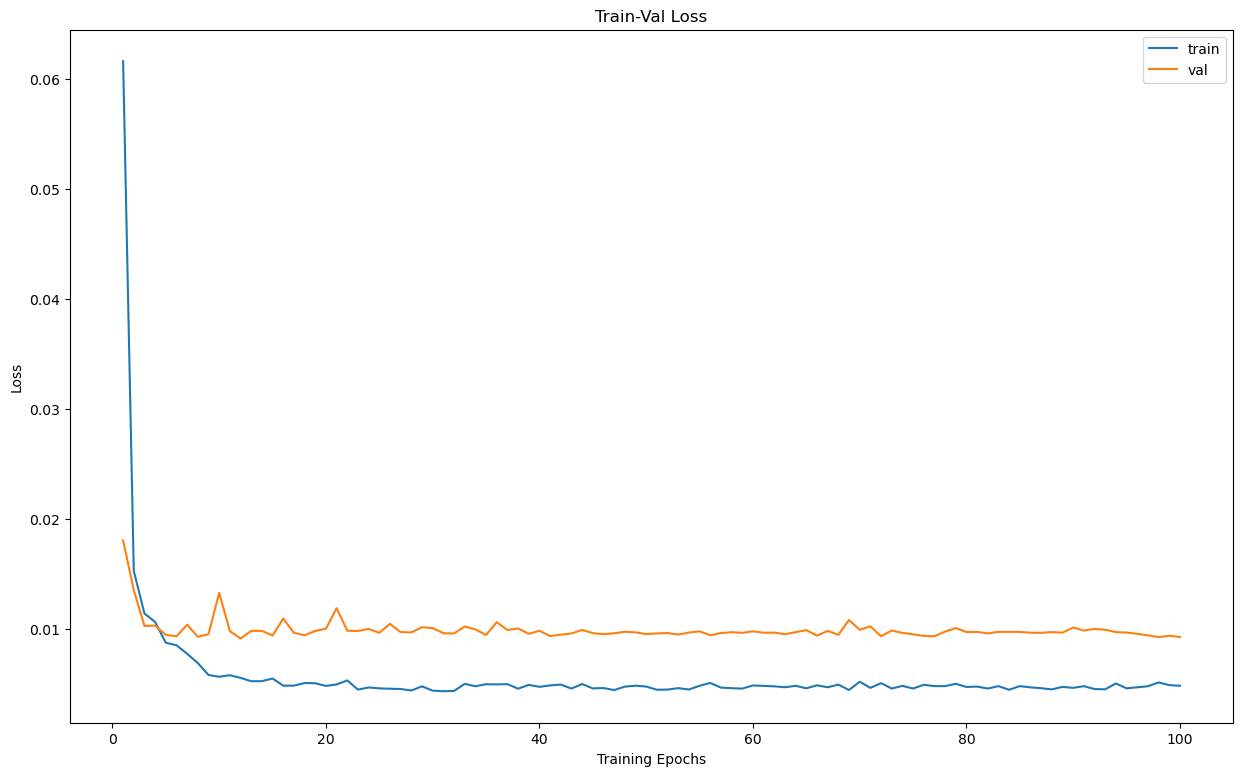

In [246]:
# 4 Next, we will plot the training and validation loss:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

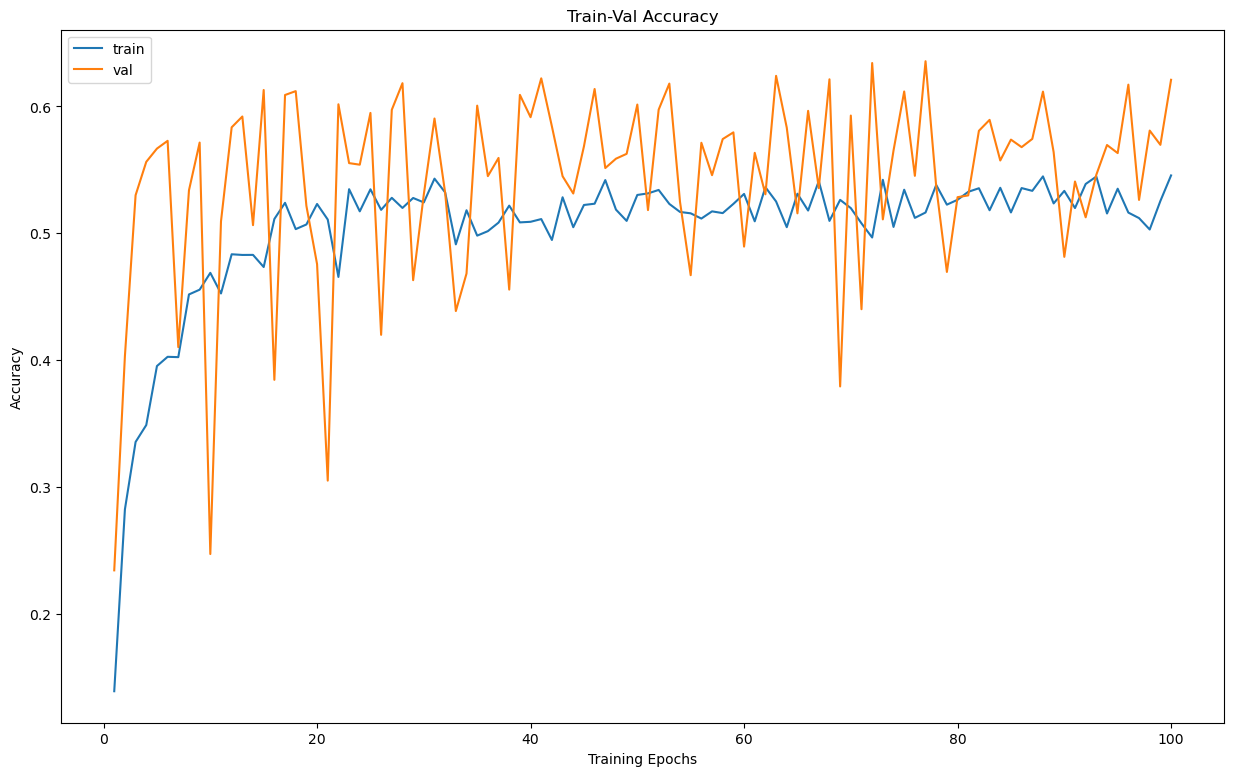

In [247]:
# Next, we will plot the IOU progress:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### **How it works**

In step 1, we defined a helper function to compute the loss and IOU metric values per epoch. The function will be used for both the training and validation datasets. For the validation dataset, no optimization is performed if `opt=None` is passed to the function. In the function, batches of data are obtained from the data loader within a loop. Remember that we needed to convert the labels to tensors. Then, the model outputs are obtained and the loss and IOU were computed per mini-batches using the `loss_batch` function.

In step 2, we defined the `train_val` function in a few steps for better code readability. The inputs to the function are the model and the training parameters. We extracted the keys from `params`. Then, we defined `loss_history` and `metric_history` to record the loss and metric values during training. During training, we want to keep the best model parameters. Thus, we defined `best_model_wts` to store the best model parameters. To be able to track the model's performance, we need to store the best loss value. For the first training epoch, there is no previous loss value, so we initialized `best_loss` to a large number or `"inf"`. Then, the main loop starts, which runs for `num_epochs` iterations. We printed the current learning rate at the beginning to keep an eye on it. Then, we set the model in training mode and trained the model. This means that the loss value is calculated and the model parameters are updated using the optimizer, with all this happening inside the `loss_epoch` function as previously described. Next, we set the model in evaluation mode and evaluated the model on the validation data. This time, no gradient calculation nor optimization were needed.

> Do not forget to set the model to its proper mode as required using the `.train()` and `.eval()` methods.

After each evaluation, we compared the current validation loss with the best loss value and stored the model parameters if a better loss was observed. Next, we passed the validation loss to the learning rate schedule. If the validation loss remains unchanged for 20 epochs, the learning rate schedule will reduce the learning rate by a factor of 2. Also, we printed the progress in each epoch to monitor the training process. Finally, the loop ends and we returned the best performing model and the history of loss and metric values. 

> <font color=yellow>Do not forget to stop `autograd` from computing the gradients during model evaluation by wrapping the code block in with `torch.no_grad():`</font>.

In step 3, we used the `train_val` function to actually train the model. We created a folder to store the model parameters as a pickle file. Then, we defined the training parameters in `params_train`. You can set the `sanity_check` flag to `True` if you want to quickly execute the function and fix any possible errors. The flag breaks a training epoch after one mini-batch, meaning the loops are executed more quickly. Then, you can return to `sanity_check=False`. As has been observed, the loss and metric values were printed.

In step 4, we plotted the training and validation loss and IOU values. The plots show the progress of the training and evaluation. 

## **Deploying the model**

We will deploy the model. We will consider two deployment cases: deployment on a PyTorch dataset, and deployment on individual images stored locally. Since there is no test dataset available, we will use the validation dataset during deployment. We assume that you want to deploy the model for inference in a new script separate from the training scripts. In this case, the dataset and model do not exist in memory. To avoid repetition, we will skip defining the dataset and model in this section. Follow the instructions in the Creating custom datasets and Creating the model recipes to define the validation dataset and model in the deployment script. In the following scripts, we will assume that you have defined `Net` for the model definition and `val_ds` and `val_dl` for the validation dataset.

We will load the model parameters from a file and deploy the model on the validation dataset and individual images:

In [248]:
# 1 First, we will create an object of the Net class:
params_model = {
        "input_shape": (3, 256, 256),
        "initial_filters": 16, 
        "num_outputs": 2,
    }
model = Net(params_model)
model.eval()

# Move the model to the CUDA device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = model.to(device)

# 2 Then, we will load the model parameters from the file:
path2weights = "../models/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))

# 3 Let's verify the model by testing on the validation dataset:
loss_func = nn.SmoothL1Loss(reduction="sum")

with torch.no_grad():
    loss,metric=loss_epoch(model,loss_func,val_dl)
print(loss,metric)

0.009168989933095872 0.5835165977478027


In [249]:
# 4 Next, we will deploy the model on the image samples from val_ds.
from PIL import ImageDraw
import numpy as np
import torchvision.transforms.functional as tv_F

np.random.seed(0)

import matplotlib.pylab as plt
%matplotlib inline

# We will define a function to display a tensor with two labels as bounding boxes:

def show_tensor_2labels(img,label1,label2,w_h=(50,50)): 
    label1 = rescale_label(label1,img.shape[1:])
    label2 = rescale_label(label2,img.shape[1:])
    img = tv_F.to_pil_image(img) 

    w, h = w_h 
    cx, cy = label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline="green", width=2)

    cx,cy = label2
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline="red", width=2)

    plt.imshow(np.asarray(img))

# We will get random sample indices:

rndInds = np.random.randint(len(val_ds), size=10)
print(rndInds)

[44 47 64 67 67  9 21 36 70 12]


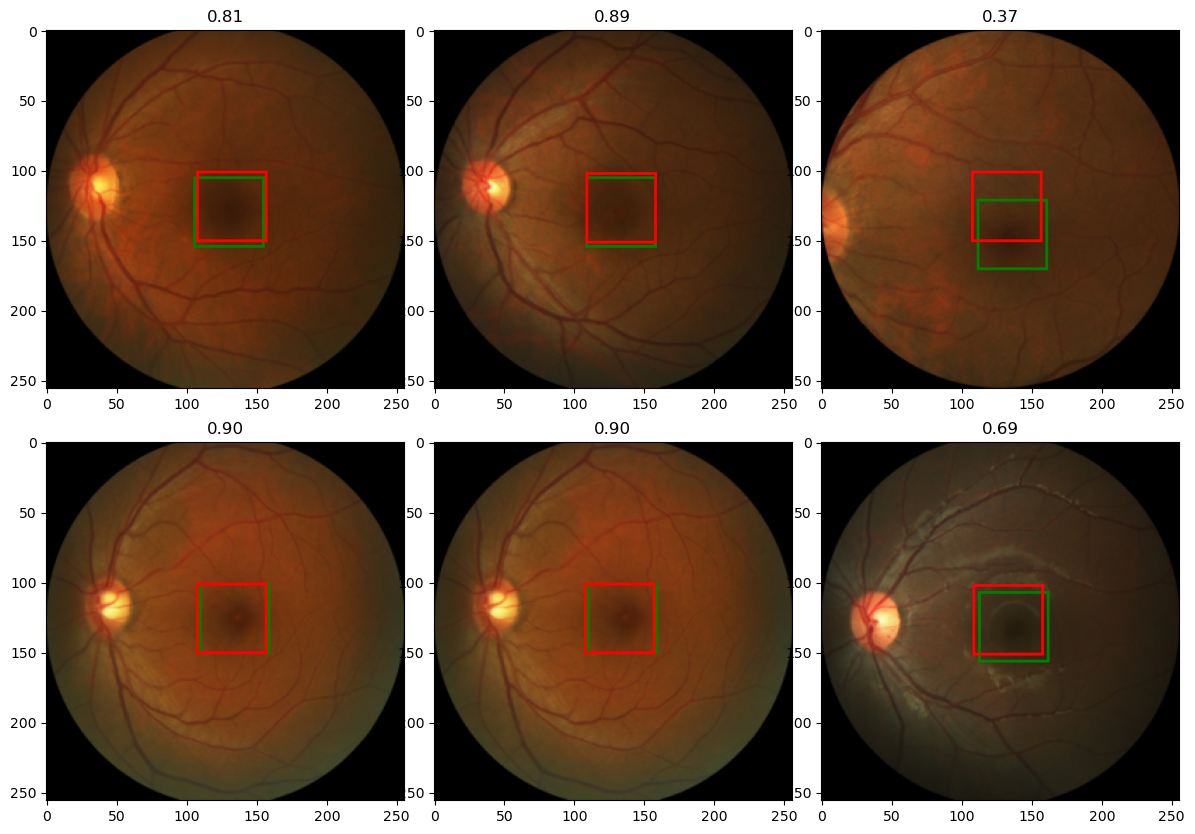

In [250]:
# Next, we will deploy the model on the samples and display the predictions together with the ground truth
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.15)

for i,rndi in enumerate(rndInds):
    img,label = val_ds[rndi]
    h, w = img.shape[1:]
    with torch.no_grad():
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
        
    plt.subplot(2, 3, i+1)
    show_tensor_2labels(img, label, label_pred)
    
    # calculate IOU 
    label_bb = cxcy2bbox(torch.tensor(label).unsqueeze(0))
    label_pred_bb = cxcy2bbox(label_pred.unsqueeze(0))
    iou=torchvision.ops.box_iou(label_bb, label_pred_bb) 
    plt.title("%.2f" %iou.item())

    if i>4:
        break

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256])


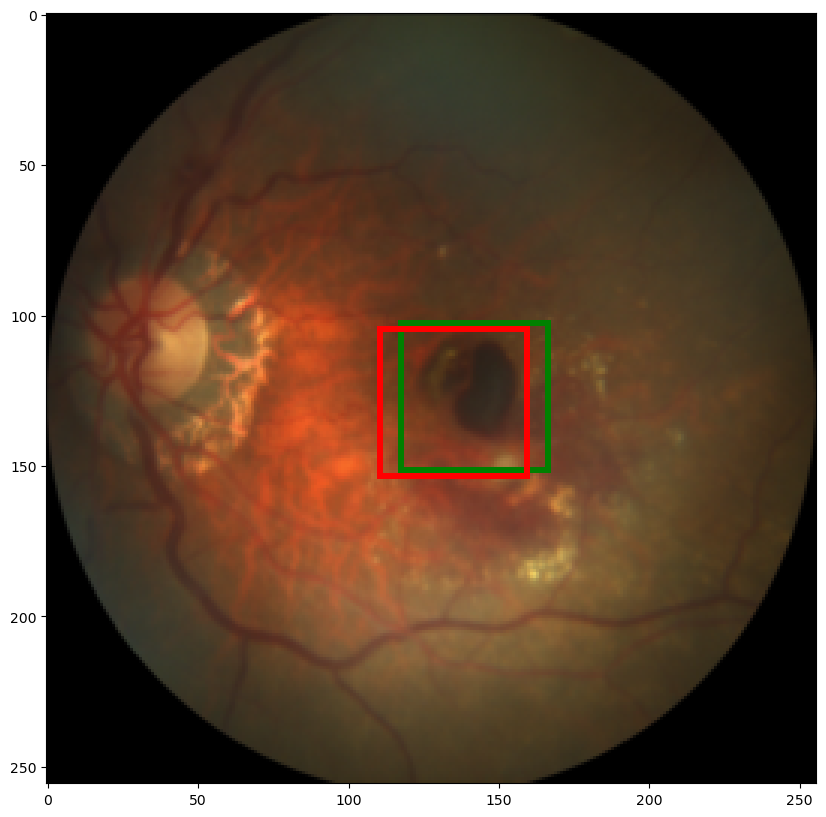

In [251]:
# 5 Next, we will deploy the model on individual images:
path2labels = os.path.join(path2data,"Training400","Fovea_location.xlsx")
labels_df = pd.read_excel(path2labels,index_col="ID")

img,label = load_img_label(labels_df, 1) 
print(img.size, label)

img,label = resize_img_label(img, label, target_size=(256, 256))
print(img.size, label)

img=TF.to_tensor(img)
label=scale_label(label, (256,256))
print(img.shape)

with torch.no_grad():
    label_pred=model(img.unsqueeze(0).to(device))[0].cpu()

show_tensor_2labels(img,label, label_pred)

In [252]:
# 6 Next, we will calculate the inference time per image:
import time
elapsed_times = []
with torch.no_grad():
    for k in range(100):
        start = time.time()
        label_pred = model(img.unsqueeze(0).to(device))[0].cpu()
        elapsed = time.time()-start
        elapsed_times.append(elapsed)
print("inference time per image: %.4f s" %np.mean(elapsed_times)) 

inference time per image: 0.0098 s


### **How it works**

In step 1, we created an object of the `Net` class and called it `model`. We assumed that you copied the scripts of the Net class from the Creating the model recipe. Note that the model parameters are randomly initialized at this point. We then moved the model to the CUDA device for accelerated processing.

If you recall from the *Training and evaluation of the model* recipe, we stored the best model parameters as a pickle file called `weights.p`.

In step 2, we loaded the model parameters from the pickle file into the model. 

In step 3, we evaluated the model on the validation dataset to verify the previous steps. Oftentimes, things may go wrong during the storing and loading of model parameters. Hence, evaluating the model on the validation dataset can verify the process. Doing that, you should see the same performance that you observed during the training process. Here, we used the `loss_epoch` function, defined in the *Defining the loss, optimizer, and IOU metric* recipe, to get the loss and metrics values on the validation dataset. 

In step 4, we deployed the model on the validation dataset. Unfortunately, we do not have a test dataset. We defined the `show_tensor_2labels` function to show the image and predictions together with the ground truth as bounding boxes. The function assumes that the image is a PyTorch tensor. We converted the tensor to a PIL image using the `to_pill_image` function from `torchvision`. Also, recall that the ground truth and predictions were scaled to the range of $[0, 1]$, so we rescaled them back to the image size. Then, we picked a set of random indices. Next, we get random images from val_ds. When you get a sample image from `val_ds`, it will be in a $3 \times 256 \times 256$ shape, hosted on the CPU. Thus, we added a new dimension to it using `unsqueeze(0)` and moved it to CUDA before passing it the model. The output is the predicted fovea coordinates. Next, **we created bounding boxes from the coordinates** using the `cxcy2bbox` function **to be able to calculate the IOU metric**. The calculated IOU was printed on top of each image. 

You may also want to deploy the model on individual images separate from `val_ds`. This can be useful for future images that will be collected as a test dataset. We showed how to do this in step 5. Assuming that the new image is stored locally, we loaded it as a `PIL` image. Then, we resized the `PIL` image to $256 \times 256$. Next, we converted the image to a PyTorch tensor using the `to_tensor` method and added a dimension to it. Finally, it was passed to the model to get the predictions.

In step 6, we are interested to know the inference time per image. This is an important factor during deployment. We measured the inference time by averaging the elapsed time per image for $100$ iterations. As a reminder, the result shows the inference time using the GPU.